In [102]:
import glob
import pickle
import tqdm
import torch
import matplotlib.pyplot as plt
from ray_optim.plot import Plot
%matplotlib inline
from ray_nn.nn.xy_hist_data_models import MetrixXYHistSurrogate, StandardizeXYHist, HistSurrogateEngine
from ray_tools.base.backend import RayBackendDockerRAYUI
from ray_tools.base.transform import MultiLayer
from ray_tools.base.engine import RayEngine
from ray_nn.data.lightning_data_module import DefaultDataModule
from datasets.metrix_simulation.config_ray_emergency_surrogate import PARAM_CONTAINER_FUNC as params
from datasets.metrix_simulation.config_ray_emergency_surrogate import TRANSFORMS as cfg_transforms
from ray_tools.base.parameter import NumericalParameter, RayParameterContainer
from ray_tools.simulation.torch_datasets import BalancedMemoryDataset, MemoryDataset, RayDataset
from sub_projects.ray_optimization.utils import ray_output_to_tensor
from sub_projects.ray_optimization.ray_optimization import RayOptimization
from ray_tools.base.utils import RandomGenerator

# Model

In [2]:
def tensor_to_param_container(ten):
    param_dict = {}
    for i, (label, entry) in enumerate(params().items()):
        if label == 'U41_318eV.numberRays':
            param_dict[label] = entry
        else:
            value = ten[i-1]*(entry.value_lims[1]-entry.value_lims[0])+entry.value_lims[0]
            param_dict[label] = NumericalParameter(value.item())
            if value.item() < entry.value_lims[0] or value.item() > entry.value_lims[1]:
                if value.item() < entry.value_lims[0]:
                    value = torch.ones_like(value) * entry.value_lims[0]
                elif value.item() > entry.value_lims[1]:
                    value = torch.ones_like(value) * entry.value_lims[1]
                #raise Exception("Out of range. Minimum was {}, maximum {} but value {}. Tensor value was {}.".format(entry.value_lims[0], entry.value_lims[1], value.item(), ten[i-1].item()))
    return RayParameterContainer(param_dict)
def mse_engines_comparison(engine, surrogate_engine, param_container_list: list[RayParameterContainer], transforms):
    out = engine.run(param_container_list, transforms)
    out_surrogate = surrogate_engine.run(param_container_list, transforms)
    std_backward = surrogate_engine.model.standardizer.destandardize
    x_simulation_hist_list = []
    y_simulation_hist_list = []
    mse_list = []
    for i in range(len(out_surrogate)):
        surrogate_hist = out_surrogate[i]['ray_output']['ImagePlane']['xy_hist']
        out_simulation = out[i]['ray_output']['ImagePlane']['0.0']
        x_simulation_hist, _ = torch.histogram(out_simulation.x_loc,bins=50, range=[-10, 10])
        x_simulation_hist_list.append(x_simulation_hist)
        y_simulation_hist, _ = torch.histogram(out_simulation.y_loc,bins=50, range=[-3, 3])
        y_simulation_hist_list.append(y_simulation_hist)
        mse = ((torch.stack([std_backward(surrogate_hist.x_loc), std_backward(surrogate_hist.y_loc)]) - torch.stack([x_simulation_hist, y_simulation_hist]))**2).mean()
        mse_list.append(mse)
    return torch.stack(mse_list), x_simulation_hist_list, y_simulation_hist_list

In [3]:
engine = RayEngine(rml_basefile='rml_src/METRIX_U41_G1_H1_318eV_PS_MLearn_1.15.rml',
                                exported_planes=["ImagePlane"],
                                ray_backend=RayBackendDockerRAYUI(docker_image='ray-ui-service',
                                                                  docker_container_name='ray-ui-service-test',
                                                                  dockerfile_path='ray_docker/rayui',
                                                                  ray_workdir='/dev/shm/ray-workdir',
                                                                  verbose=False),
                                num_workers=-1,
                                as_generator=False)
surrogate_engine = HistSurrogateEngine(checkpoint_path="outputs/xy_hist/i7sryekx/checkpoints/epoch=174-step=42782950.ckpt")

/home/dmeier/.venv/lib64/python3.11/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Sequential(
  (0): Linear(in_features=34, out_features=68, bias=True)
  (1): Mish()
  (2): Linear(in_features=68, out_features=72, bias=True)
  (3): Mish()
  (4): Linear(in_features=72, out_features=77, bias=True)
  (5): Mish()
  (6): Linear(in_features=77, out_features=82, bias=True)
  (7): Mish()
  (8): Linear(in_features=82, out_features=87, bias=True)
  (9): Mish()
  (10): Linear(in_features=87, out_features=93, bias=True)
  (11): Mish()
  (12): Linear(in_features=93, out_features=100, bias=True)
  (13): Sigmoid()
)


/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654

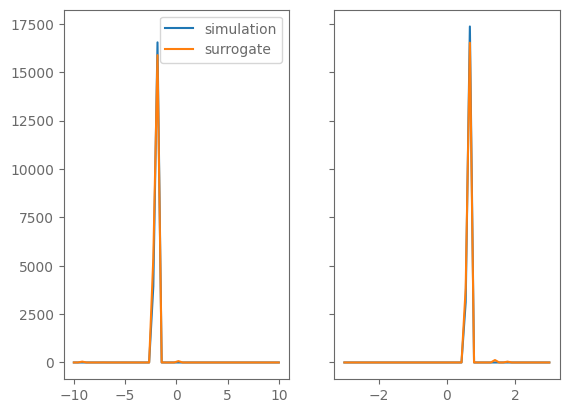

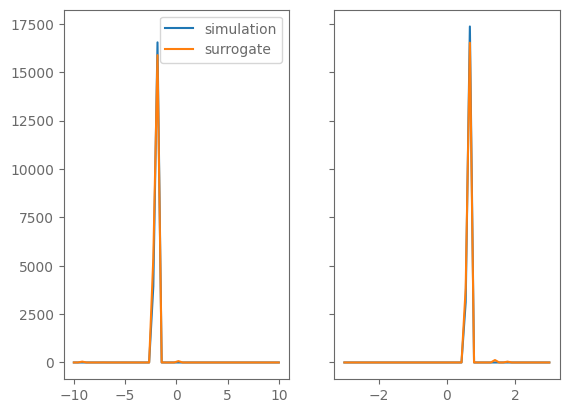

In [4]:
Plot.plot_engines_comparison(engine, surrogate_engine, [tensor_to_param_container(torch.ones((34))*0.5)], MultiLayer([0.]))

# Datamodule

In [8]:
load_len: int | None = 10000
h5_files = list(glob.iglob('datasets/metrix_simulation/ray_emergency_surrogate/data_raw_*.h5'))
dataset = RayDataset(h5_files=h5_files,
                        sub_groups=['1e5/params',
                                    '1e5/ray_output/ImagePlane/histogram', '1e5/ray_output/ImagePlane/n_rays'], transform=Select(keys=['1e5/params', '1e5/ray_output/ImagePlane/histogram', '1e5/ray_output/ImagePlane/n_rays'], search_space=params(), non_dict_transform={'1e5/ray_output/ImagePlane/histogram': surrogate_engine.model.standardizer}))


bal_memory_dataset = BalancedMemoryDataset(dataset=dataset, load_len=load_len, min_n_rays=500)
memory_dataset = MemoryDataset(dataset=dataset, load_len=load_len)
datamodule = DefaultDataModule(dataset=bal_memory_dataset, num_workers=4)
datamodule.prepare_data()
datamodule.setup(stage="test")
test_dl = datamodule.test_dataloader()

unbal_datamodule = DefaultDataModule(dataset=memory_dataset, num_workers=4)
unbal_datamodule.prepare_data()
unbal_datamodule.setup(stage="test")
unbal_test_dl = unbal_datamodule.test_dataloader()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:57<00:00, 42.09it/s]


## Maximum distribution

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 38.23it/s]


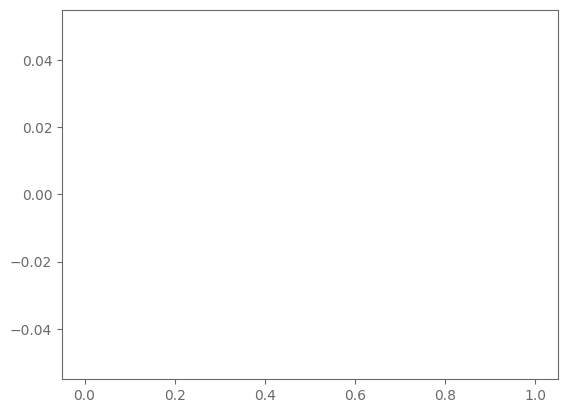

In [9]:
value_list = []
params_list = []

for i in tqdm.tqdm(unbal_test_dl):
    biggest = i[1].flatten(start_dim=1)
    biggest, _ = i[1].flatten(start_dim=1).max(dim=1)
    mask = biggest > 0.8
    value_list.append(biggest[mask])
    params_list.append(i[0][mask])
value_tensor = torch.cat(value_list)
params_tensor = torch.cat(params_list)

torch.save(value_tensor, 'outputs/values.pt')
torch.save(params_tensor, 'outputs/params.pt')
plt.hist(value_tensor)
plt.savefig('outputs/max_dist_hist.png')

In [5]:
value_tensor = torch.load('outputs/values.pt')
params_tensor = torch.load('outputs/params.pt')

/tmp/ipykernel_9029/3069755826.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  value_tensor = torch.load('outputs/values.pt')
/tmp/ipykernel_9029/3069755826.py:2: Future

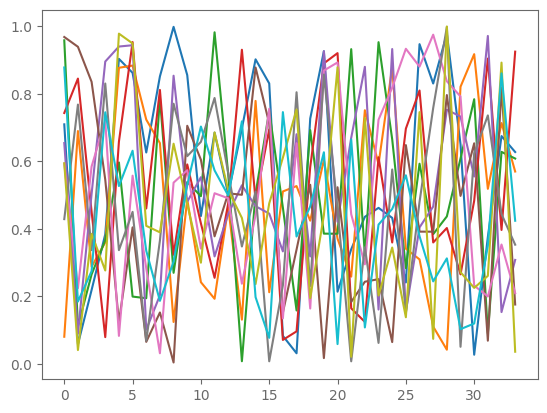

# Special sample

In [70]:
with open("outputs/special_sample_168_selected.pkl", "rb") as f:
    special_sample = pickle.load(f, fix_imports=True, encoding='ASCII', errors='strict', buffers=None)
observed_params = special_sample.uncompensated_parameters

for param_container in observed_params:
    for label in ['ImagePlane.translationXerror', 'ImagePlane.translationYerror', 'ImagePlane.translationZerror']:
        if label in list(param_container.keys()):
            del param_container[label]

/home/dmeier/.venv/lib64/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [69]:
len(observed_params)
Plot.plot_engines_comparison(engine, surrogate_engine, observed_params[:5], MultiLayer([0.]), )

0

In [56]:
uncompensated_parameters = [elem.clone() for elem in special_sample.uncompensated_parameters]
for elem in uncompensated_parameters:
    elem.perturb(special_sample.target_params)
uncompensated_parameters[0]

RayParameterContainer([('U41_318eV.numberRays', NumericalParameter: 10000.0),
                       ('U41_318eV.translationXerror',
                        RandomParameter: -0.004539263227855021),
                       ('U41_318eV.translationYerror',
                        RandomParameter: 0.0066464056966137365),
                       ('U41_318eV.rotationXerror',
                        RandomParameter: -0.002970777585433936),
                       ('U41_318eV.rotationYerror',
                        RandomParameter: -0.0007330520915379123),
                       ('ASBL.totalWidth',
                        RandomParameter: 2.0037125063427057),
                       ('ASBL.totalHeight',
                        RandomParameter: 1.0076306848568606),
                       ('ASBL.translationXerror',
                        RandomParameter: 0.004668169726248672),
                       ('ASBL.translationYerror',
                        RandomParameter: 0.0032402599615711687),
       

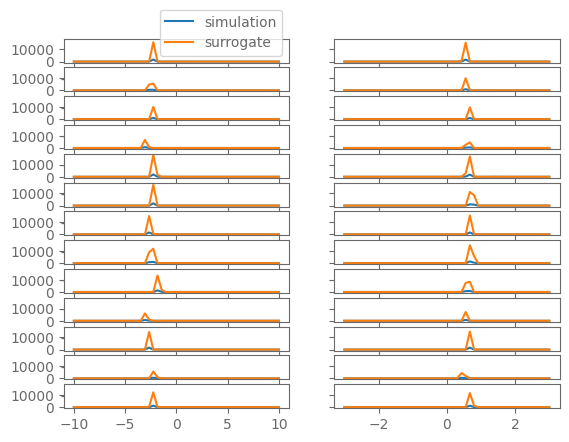

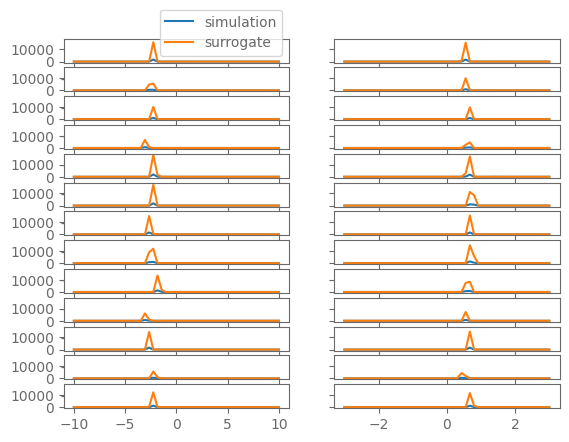

In [64]:
Plot.plot_engines_comparison(engine, surrogate_engine, uncompensated_parameters, MultiLayer([0.]))

(array([1., 1., 1., 0., 0., 0., 0., 1., 0., 1.]),
 array([ 580844.9375, 1013499.6875, 1446154.5   , 1878809.25  ,
        2311464.    , 2744118.75  , 3176773.5   , 3609428.25  ,
        4042083.    , 4474737.5   , 4907392.5   ]),
 <BarContainer object of 10 artists>)

<Figure size 640x480 with 0 Axes>

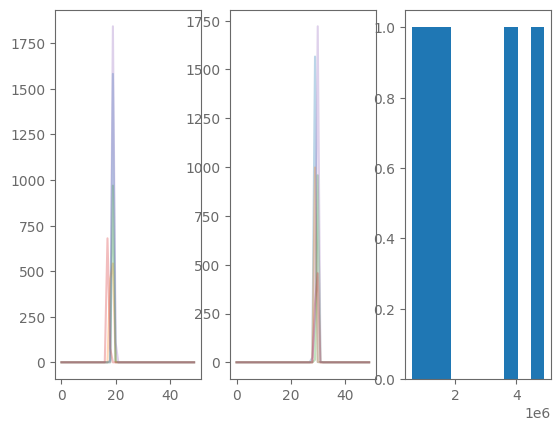

In [61]:
mse_comparison, x_simulation_hist, y_simulation_hist = mse_engines_comparison(engine, surrogate_engine, uncompensated_parameters[:5], MultiLayer([0.]))
plt.clf()
fig, ax = plt.subplots(1, 3)
for hist in x_simulation_hist:
    ax[0].plot(hist, alpha=0.3)
for hist in y_simulation_hist:
    ax[1].plot(hist, alpha=0.3)
ax[2].hist(mse_comparison)

In [65]:
x_loc_list = []
good_param_list = []
batch_size = 5000
for i in tqdm.trange(15000//batch_size):
    param_container = [tensor_to_param_container(torch.rand((34,))) for _ in range(batch_size)]
    surrogate_out = surrogate_engine.run(param_container, MultiLayer([0.]))
    for j in range(len(param_container)):
        output = surrogate_out[j]['ray_output']['ImagePlane']['xy_hist']
        if output.x_loc.sum() > 0.5:
            x_loc_list.append(output.x_loc.sum())
            good_param_list.append(param_container[j])

observed_containers_tensor = torch.vstack([surrogate_engine.select({"1e5/params":param_container})[0] for param_container in observed_params])
good_containers_tensor = torch.vstack([surrogate_engine.select({"1e5/params":param_container})[0] for param_container in good_param_list])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:53<00:00, 17.86s/it]


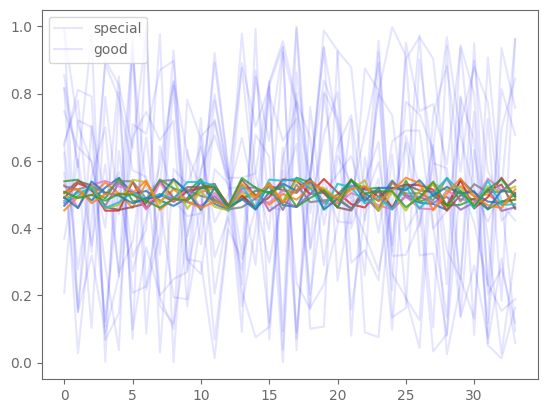

In [67]:
plt.clf()
for i in range(good_containers_tensor.shape[0]):
    plt.plot(good_containers_tensor[i], c = 'blue', alpha=0.1)
for i in range(observed_containers_tensor.shape[0]):
    plt.plot(observed_containers_tensor[i], alpha=0.8)
plt.legend(["special", "good"])

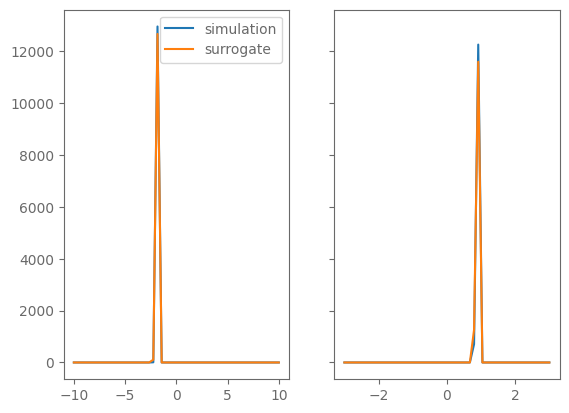

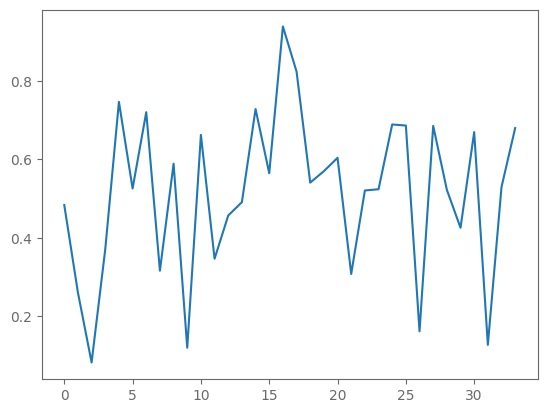

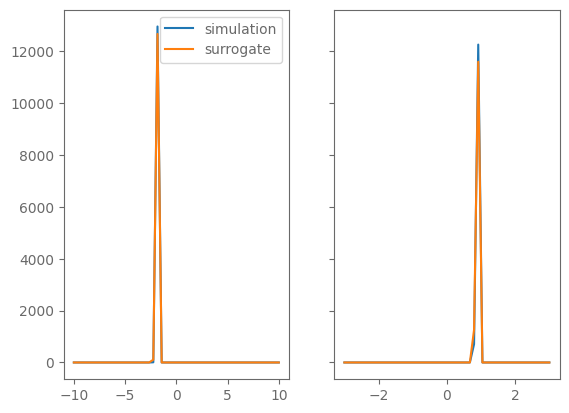

In [43]:
#mask = value_tensor > 0.44
out = ((params_tensor - observed_containers_tensor[0].unsqueeze(0))**2)/2.
out = out.mean(dim=1)
out_sorted, indices = torch.sort(out)
#part_indices = indices[:5]
#print(part_indices.shape)
#min_arg = out.argmin()
#plt.hist(out.mean(dim=1))
#plt.plot(params_tensor[min_arg])
#plt.plot(observed_containers_tensor[0])
for i in indices[:1]:
    plt.plot(params_tensor[i])
Plot.plot_engines_comparison(engine, surrogate_engine, [tensor_to_param_container(params_tensor[min_arg]) for min_arg in indices[:1]], MultiLayer([0.]), )

In [24]:
#surrogate_engine.run(observed_params)
model = MetrixXYHistSurrogate.load_from_checkpoint("outputs/xy_hist/i7sryekx_copy/checkpoints/epoch=186-step=45716638.ckpt")
select = Select(keys=['1e5/params'], omit_ray_params=['U41_318eV.numberRays'], search_space=params(), non_dict_transform={'1e5/ray_output/ImagePlane/histogram': model.standardizer})
param_containers_tensor = torch.vstack([select({"1e5/params":param_container})[0] for param_container in observed_params])
with torch.no_grad():
    out_model = model(param_containers_tensor)


/home/dmeier/.venv/lib64/python3.11/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/dmeier/.venv/lib64/python3.11/site-packages/t

Sequential(
  (0): Linear(in_features=34, out_features=68, bias=True)
  (1): Mish()
  (2): Linear(in_features=68, out_features=72, bias=True)
  (3): Mish()
  (4): Linear(in_features=72, out_features=77, bias=True)
  (5): Mish()
  (6): Linear(in_features=77, out_features=82, bias=True)
  (7): Mish()
  (8): Linear(in_features=82, out_features=87, bias=True)
  (9): Mish()
  (10): Linear(in_features=87, out_features=93, bias=True)
  (11): Mish()
  (12): Linear(in_features=93, out_features=100, bias=True)
  (13): Sigmoid()
)


In [34]:
transforms = {"ImagePlane": transform for transform in cfg_transforms}
out_engine = engine.run(observed_params, transforms)

In [53]:
standardized_simulations = surrogate_engine.model.standardizer(torch.vstack([element['ray_output']['ImagePlane']['histogram'].flatten(start_dim=0) for element in out_engine]))
a = ((standardized_simulations - out_model)**2).mean(dim=1)

(array([2., 3., 2., 2., 2., 0., 0., 2., 1., 1.]),
 array([0.0007691 , 0.00143994, 0.00211078, 0.00278163, 0.00345247,
        0.00412331, 0.00479415, 0.00546499, 0.00613584, 0.00680668,
        0.00747752]),
 <BarContainer object of 10 artists>)

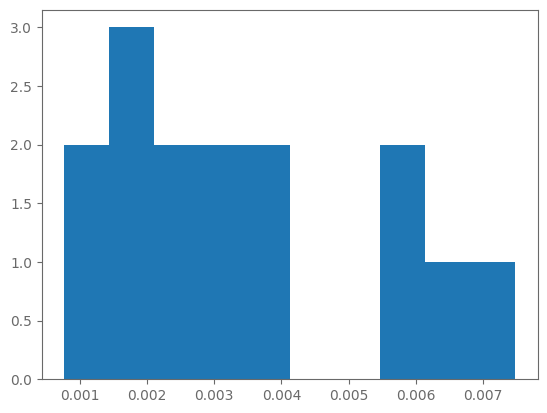

In [55]:
plt.hist(a)

# Good params vs. bad params

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 373165.36it/s]


(array([9.812e+03, 5.500e+01, 2.600e+01, 3.300e+01, 2.400e+01, 2.100e+01,
        1.000e+01, 1.100e+01, 7.000e+00, 1.000e+00]),
 array([    0. ,  1400.5,  2801. ,  4201.5,  5602. ,  7002.5,  8403. ,
         9803.5, 11204. , 12604.5, 14005. ]),
 <BarContainer object of 10 artists>)

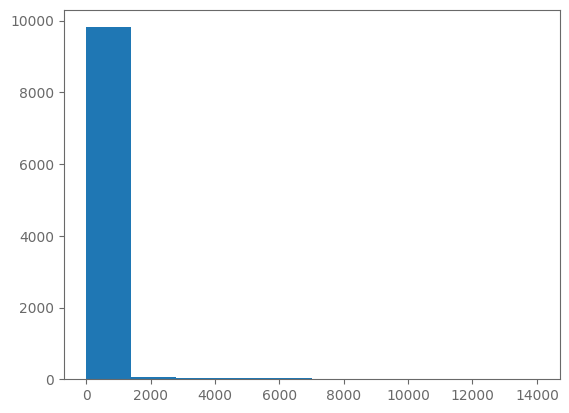

In [66]:
params_list = []
num_rays_list = []
for i in tqdm.tqdm(memory_dataset):
    params_list.append(i[0])
    num_rays_list.append(i[2])
params_tensor = torch.vstack(params_list)
num_rays_tensor= torch.vstack(num_rays_list)
plt.hist(torch.tensor(num_rays_list))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:45<00:00,  8.27s/it]


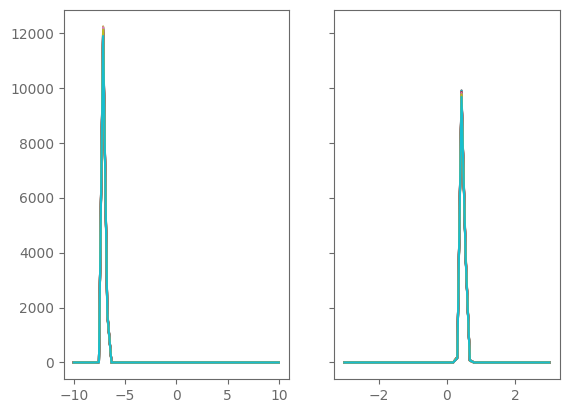

In [74]:
biggest = torch.tensor(num_rays_list).argmax()
test_parameters = memory_dataset[biggest][0]
param_container_list = [tensor_to_param_container(test_parameters)]

fig, ax = plt.subplots(1,2, sharey=True, squeeze=False)

for i in tqdm.trange(20):
    out = engine.run(param_container_list, MultiLayer([0.]))
    out_simulation = out[-1]['ray_output']['ImagePlane']['0.0']
    x_simulation_hist, _ = torch.histogram(out_simulation.x_loc,bins=50, range=[-10, 10])
    y_simulation_hist, _ = torch.histogram(out_simulation.y_loc,bins=50, range=[-3, 3])
    ax[0, 0].plot(torch.linspace(-10, 10, 50), x_simulation_hist)
    ax[0, 1].plot(torch.linspace(-3, 3, 50), y_simulation_hist)

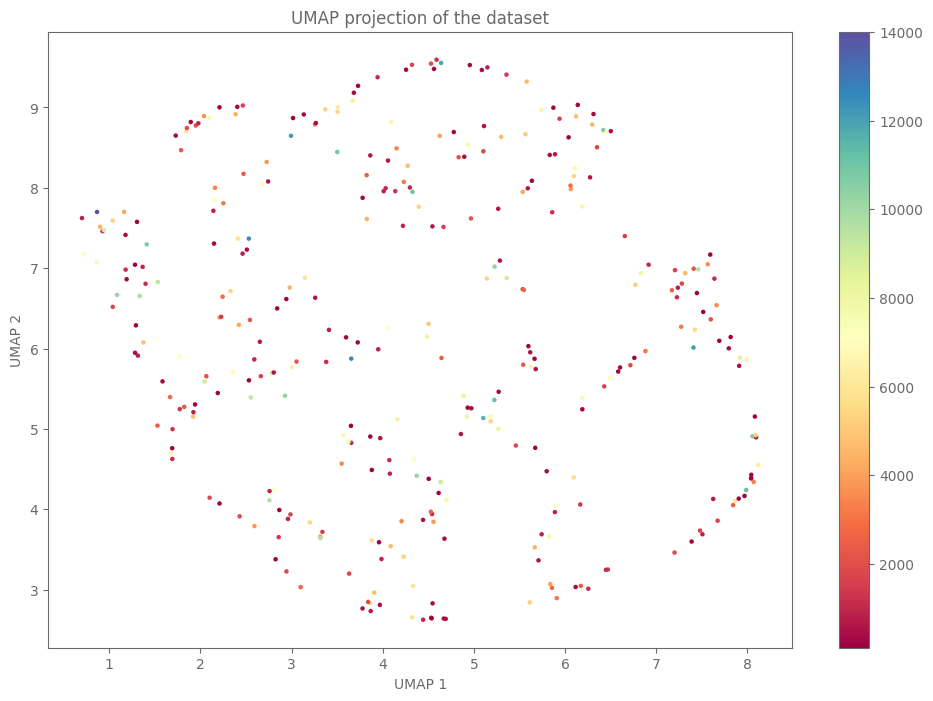

In [27]:
import umap
mask = num_rays_tensor > 100.
data_tensor = params_tensor[mask.flatten()]
data_tensor = data_tensor[:,:4]
class_tensor = num_rays_tensor[mask]

data_np = data_tensor.numpy()
class_np = class_tensor.numpy().flatten()

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
umap_embedding = umap_model.fit_transform(data_np)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=class_np, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title('UMAP projection of the dataset')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

/home/dmeier/.venv/lib64/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


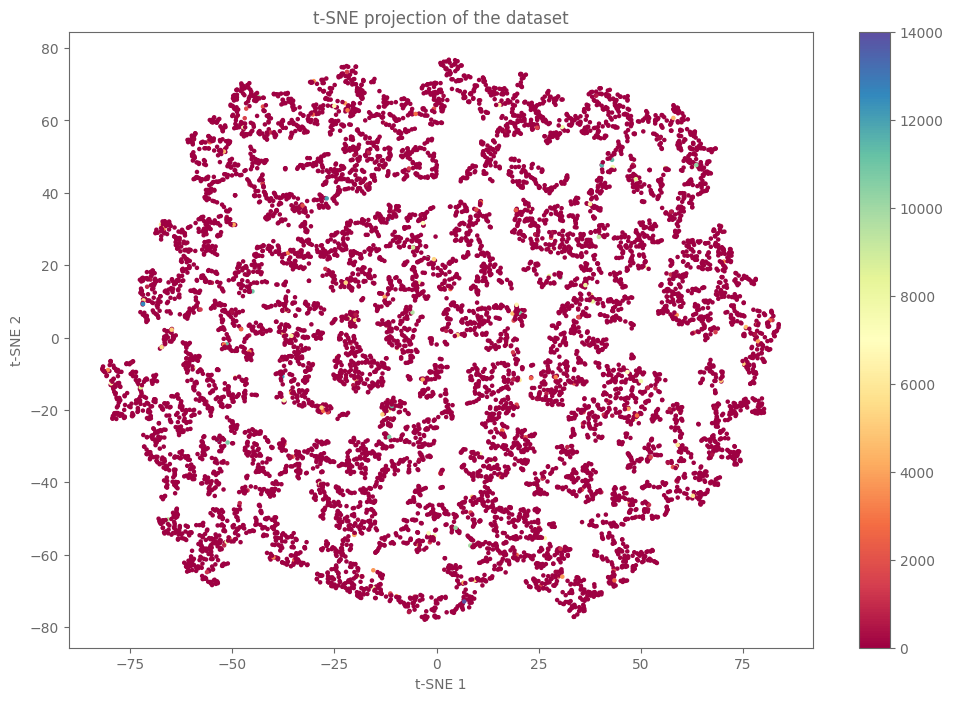

In [26]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=30, learning_rate=200, max_iter=1000)
tsne_embedding = tsne_model.fit_transform(data_np)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=class_np, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title('t-SNE projection of the dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [6]:
import glob
import tqdm
import matplotlib.pyplot as plt
import torch

from ray_nn.nn.xy_hist_data_models import MetrixXYHistSurrogate, StandardizeXYHist
from ray_tools.simulation.torch_datasets import MemoryDataset, RayDataset
from datasets.metrix_simulation.config_ray_emergency_surrogate import PARAM_CONTAINER_FUNC as params
from torch.utils.data import DataLoader
from ray_nn.data.transform import Select


model = MetrixXYHistSurrogate.load_from_checkpoint("outputs/xy_hist/i7sryekx/checkpoints/epoch=174-step=42782950.ckpt")
model.to(torch.device('cpu'))
model.compile()
model.eval()

load_len: int | None = None
h5_files = list(glob.iglob('datasets/metrix_simulation/ray_emergency_surrogate/selected/data_raw_*.h5'))
dataset = RayDataset(h5_files=h5_files,
                        sub_groups=['1e5/params',
                                    '1e5/ray_output/ImagePlane/histogram', '1e5/ray_output/ImagePlane/n_rays'], transform=Select(keys=['1e5/params', '1e5/ray_output/ImagePlane/histogram', '1e5/ray_output/ImagePlane/n_rays'], search_space=params(), non_dict_transform={'1e5/ray_output/ImagePlane/histogram': model.standardizer}))


memory_dataset = MemoryDataset(dataset=dataset, load_len=load_len)

train_dataloader = DataLoader(memory_dataset, batch_size=2048, shuffle=False, num_workers=0)

errors_list = []
with torch.no_grad():
    for par_input, label, _ in tqdm.tqdm(train_dataloader):
        out = model(par_input)
        label = label.flatten(start_dim=1)
        b = ((label - out)**2).mean(dim=1)
        errors_list.append(b)
errors_tensor = torch.cat(errors_list)

plt.hist(errors_tensor)
plt.savefig('outputs/dataset_errors_hist.png')
torch.save(errors_tensor, 'outputs/dataset_errors.pt')

/home/dmeier/.venv/lib64/python3.11/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Sequential(
  (0): Linear(in_features=34, out_features=68, bias=True)
  (1): Mish()
  (2): Linear(in_features=68, out_features=72, bias=True)
  (3): Mish()
  (4): Linear(in_features=72, out_features=77, bias=True)
  (5): Mish()
  (6): Linear(in_features=77, out_features=82, bias=True)
  (7): Mish()
  (8): Linear(in_features=82, out_features=87, bias=True)
  (9): Mish()
  (10): Linear(in_features=87, out_features=93, bias=True)
  (11): Mish()
  (12): Linear(in_features=93, out_features=100, bias=True)
  (13): Sigmoid()
)


  0%|                                                                                                                                                                             | 0/1 [00:00<?, ?it/s]/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/dmeier/.venv/lib64/pytho

# Look with model for new sample

In [4]:
torch.set_default_device('cuda')

model = MetrixXYHistSurrogate.load_from_checkpoint("outputs/xy_hist/i7sryekx/checkpoints/epoch=174-step=42782950.ckpt")
model.compile()
model.eval()

Sequential(
  (0): Linear(in_features=34, out_features=68, bias=True)
  (1): Mish()
  (2): Linear(in_features=68, out_features=72, bias=True)
  (3): Mish()
  (4): Linear(in_features=72, out_features=77, bias=True)
  (5): Mish()
  (6): Linear(in_features=77, out_features=82, bias=True)
  (7): Mish()
  (8): Linear(in_features=82, out_features=87, bias=True)
  (9): Mish()
  (10): Linear(in_features=87, out_features=93, bias=True)
  (11): Mish()
  (12): Linear(in_features=93, out_features=100, bias=True)
  (13): Sigmoid()
)


MetrixXYHistSurrogate(
  (net): Sequential(
    (0): Linear(in_features=34, out_features=68, bias=True)
    (1): Mish()
    (2): Linear(in_features=68, out_features=72, bias=True)
    (3): Mish()
    (4): Linear(in_features=72, out_features=77, bias=True)
    (5): Mish()
    (6): Linear(in_features=77, out_features=82, bias=True)
    (7): Mish()
    (8): Linear(in_features=82, out_features=87, bias=True)
    (9): Mish()
    (10): Linear(in_features=87, out_features=93, bias=True)
    (11): Mish()
    (12): Linear(in_features=93, out_features=100, bias=True)
    (13): Sigmoid()
  )
)

In [5]:
torch.set_default_device('cuda')
offset_trials = 100
max_offset = 0.2
beamline_trials = 1000

for i in tqdm.tqdm(range(10000)):
    offsets = (torch.rand(1, offset_trials, 34) * max_offset * 2) - max_offset
    uncompensated_parameters = torch.rand(beamline_trials, 1, 34)
    tensor_sum = offsets + uncompensated_parameters
    tensor_sum = torch.clamp(tensor_sum, 0, 1)
    uncompensated_parameters = tensor_sum - offsets
    with torch.no_grad():
        compensated_rays = model(tensor_sum)
        #condition = compensated_rays.sum(dim=-1) > 1.3
        condition = (compensated_rays.sum(dim=-1)>0.5).sum(dim=0)>15
        if condition.any():
            result = (compensated_rays.sum(dim=-1)>0.5).sum(dim=0)[condition]
            print(str(len(result))+" results.")
            condition_args = torch.arange(len(condition))[condition][:1]
            mask = compensated_rays[:, condition_args[0]].sum(dim=-1)>0.5
            to_plot_tensor = tensor_sum[:, condition_args][mask]
            uncompensated_parameters_selected = uncompensated_parameters[:, condition_args][mask]
            offsets_selected = offsets[:, condition_args]
            #print(compensated_rays[condition])
            break
            

  0%|                                                                                                                                                                         | 0/10000 [00:14<?, ?it/s]

1 results.


In [6]:
compensated_parameters_selected = uncompensated_parameters_selected+offsets_selected

#torch.save(offsets_selected, 'outputs/offsets_selected.pt')
#torch.save(uncompensated_parameters_selected, 'outputs/uncompensated_parameters_selected.pt')

16


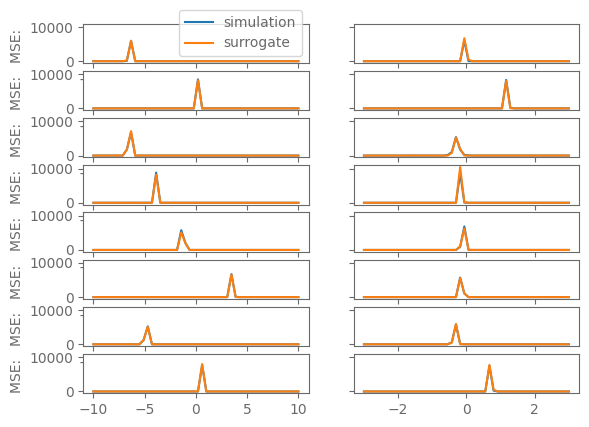

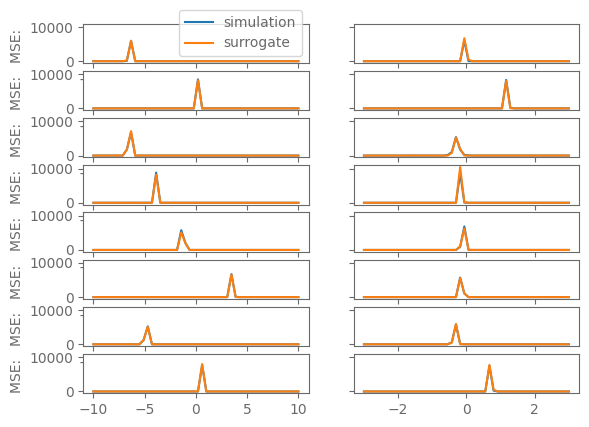

In [7]:
torch.set_default_device('cpu')
pc = [tensor_to_param_container(compensated_parameters_selected[i][0]) for i in range(compensated_parameters_selected.shape[0])]
print(len(pc))
Plot.plot_engines_comparison(engine, surrogate_engine, pc[:8], MultiLayer([0.]), )

In [8]:
torch.set_default_device('cuda')
with torch.no_grad():
    observed_rays = model(uncompensated_parameters_selected + offsets_selected)
offset_trials = 100000
max_offset = 0.2

loss_min = float('inf')
pbar = tqdm.trange(1000)

with torch.no_grad():
    for i in pbar:
        offsets = (torch.rand(1, offset_trials, 34) * max_offset * 2) - max_offset
        tensor_sum = offsets + uncompensated_parameters_selected
        
        compensated_rays = model(tensor_sum)
        loss_orig = ((compensated_rays - observed_rays) ** 2).mean(0).mean(-1)
        loss = loss_orig.min()
        if loss < loss_min:
            loss_min = loss
            loss_min_params = tensor_sum[:, loss_orig.argmin(), :]
            pbar.set_postfix({"loss": loss_min.item()})
            

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:21<00:00, 12.28it/s, loss=8.55e-5]


In [83]:
torch.set_default_device('cuda')

num_candidates = 100000
max_offset = 0.2
step_width = 0.02
num_iterations = 1000

with torch.no_grad():
    observed_rays = model(uncompensated_parameters_selected + offsets_selected)

loss_min = float('inf')
offsets = (torch.rand(1, num_candidates, 34) * max_offset * 2) - max_offset

pbar = tqdm.trange(num_iterations)
with torch.no_grad():
    for i in pbar:
        offsets = offsets + (torch.randn(offsets.shape[0], num_candidates, offsets.shape[-1]) * step_width)
        print(offsets.shape)
        offsets = torch.clamp(offsets, -max_offset, max_offset)
        tensor_sum = offsets + uncompensated_parameters_selected
        
        compensated_rays = model(tensor_sum)
        loss_orig = ((compensated_rays - observed_rays) ** 2).mean(0).mean(-1)
    
        loss = loss_orig.min()
        offsets = offsets[:, loss_orig.argmin(), :].unsqueeze(dim=1)
        if loss < loss_min:
            loss_min = loss.item()
            loss_min_params = tensor_sum[:, loss_orig.argmin(), :]
            pbar.set_postfix({"loss": loss.item()})

  0%|▏                                                                                                                                                  | 1/1000 [00:00<02:21,  7.07it/s, loss=0.000422]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  0%|▌                                                                                                                                                   | 4/1000 [00:00<01:43,  9.59it/s, loss=0.00018]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  1%|█                                                                                                                                                   | 7/1000 [00:00<01:39,  9.95it/s, loss=8.42e-5]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  1%|█▏                                                                                                                                                  | 8/1000 [00:00<01:39,  9.93it/s, loss=4.86e-5]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  1%|█▊                                                                                                                                                 | 12/1000 [00:01<01:37, 10.18it/s, loss=3.45e-5]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  1%|██                                                                                                                                                 | 14/1000 [00:01<01:35, 10.28it/s, loss=2.29e-5]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  2%|██▋                                                                                                                                                 | 18/1000 [00:01<01:32, 10.61it/s, loss=1.9e-5]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  2%|██▉                                                                                                                                                | 20/1000 [00:01<01:32, 10.64it/s, loss=1.88e-5]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  2%|███▌                                                                                                                                               | 24/1000 [00:02<01:31, 10.65it/s, loss=1.66e-5]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  3%|███▊                                                                                                                                                | 26/1000 [00:02<01:31, 10.65it/s, loss=9.9e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  3%|████▍                                                                                                                                              | 30/1000 [00:02<01:29, 10.85it/s, loss=8.33e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  3%|████▋                                                                                                                                              | 32/1000 [00:03<01:29, 10.85it/s, loss=8.33e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  4%|█████▎                                                                                                                                             | 36/1000 [00:03<01:27, 11.02it/s, loss=8.33e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  4%|█████▌                                                                                                                                             | 38/1000 [00:03<01:26, 11.09it/s, loss=8.33e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  4%|██████▏                                                                                                                                            | 42/1000 [00:03<01:25, 11.20it/s, loss=8.33e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  4%|██████▍                                                                                                                                            | 44/1000 [00:04<01:25, 11.19it/s, loss=8.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  5%|███████                                                                                                                                            | 48/1000 [00:04<01:26, 10.97it/s, loss=8.06e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  5%|███████▎                                                                                                                                           | 50/1000 [00:04<01:26, 10.94it/s, loss=7.59e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  5%|███████▉                                                                                                                                           | 54/1000 [00:05<01:25, 11.04it/s, loss=7.59e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  6%|████████▏                                                                                                                                          | 56/1000 [00:05<01:25, 11.10it/s, loss=7.59e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  6%|████████▊                                                                                                                                          | 60/1000 [00:05<01:24, 11.14it/s, loss=7.59e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  6%|█████████                                                                                                                                          | 62/1000 [00:05<01:24, 11.15it/s, loss=7.59e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  7%|█████████▋                                                                                                                                         | 66/1000 [00:06<01:23, 11.17it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  7%|█████████▉                                                                                                                                         | 68/1000 [00:06<01:23, 11.18it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  7%|██████████▌                                                                                                                                        | 72/1000 [00:06<01:23, 11.15it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  7%|██████████▉                                                                                                                                        | 74/1000 [00:06<01:22, 11.17it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  8%|███████████▍                                                                                                                                       | 78/1000 [00:07<01:22, 11.22it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  8%|███████████▊                                                                                                                                       | 80/1000 [00:07<01:21, 11.25it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  8%|████████████▎                                                                                                                                      | 84/1000 [00:07<01:21, 11.26it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  9%|████████████▋                                                                                                                                      | 86/1000 [00:07<01:21, 11.28it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  9%|████████████▉                                                                                                                                      | 88/1000 [00:08<01:25, 10.63it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  9%|█████████████▌                                                                                                                                     | 92/1000 [00:08<01:23, 10.88it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


  9%|█████████████▊                                                                                                                                     | 94/1000 [00:08<01:22, 10.94it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 10%|██████████████▍                                                                                                                                    | 98/1000 [00:09<01:21, 11.04it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 10%|██████████████▌                                                                                                                                   | 100/1000 [00:09<01:20, 11.11it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 10%|███████████████▏                                                                                                                                  | 104/1000 [00:09<01:20, 11.16it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 11%|███████████████▍                                                                                                                                  | 106/1000 [00:09<01:20, 11.17it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 11%|████████████████                                                                                                                                  | 110/1000 [00:10<01:19, 11.20it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 11%|████████████████▎                                                                                                                                 | 112/1000 [00:10<01:19, 11.18it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 12%|████████████████▉                                                                                                                                 | 116/1000 [00:10<01:18, 11.20it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 12%|█████████████████▏                                                                                                                                | 118/1000 [00:10<01:19, 11.15it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 12%|█████████████████▊                                                                                                                                | 122/1000 [00:11<01:19, 11.09it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 12%|██████████████████                                                                                                                                | 124/1000 [00:11<01:18, 11.11it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 13%|██████████████████▋                                                                                                                               | 128/1000 [00:11<01:17, 11.19it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 13%|██████████████████▉                                                                                                                               | 130/1000 [00:11<01:17, 11.21it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 13%|███████████████████▌                                                                                                                              | 134/1000 [00:12<01:17, 11.23it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 14%|███████████████████▊                                                                                                                              | 136/1000 [00:12<01:16, 11.23it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 14%|████████████████████▍                                                                                                                             | 140/1000 [00:12<01:16, 11.23it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 14%|████████████████████▋                                                                                                                             | 142/1000 [00:12<01:16, 11.17it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 15%|█████████████████████▎                                                                                                                            | 146/1000 [00:13<01:16, 11.14it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 15%|█████████████████████▌                                                                                                                            | 148/1000 [00:13<01:16, 11.17it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 15%|██████████████████████▏                                                                                                                           | 152/1000 [00:13<01:15, 11.20it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 15%|██████████████████████▍                                                                                                                           | 154/1000 [00:14<01:15, 11.20it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 16%|███████████████████████                                                                                                                           | 158/1000 [00:14<01:15, 11.16it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 16%|███████████████████████▎                                                                                                                          | 160/1000 [00:14<01:15, 11.10it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 16%|███████████████████████▉                                                                                                                          | 164/1000 [00:14<01:15, 11.07it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 17%|████████████████████████▏                                                                                                                         | 166/1000 [00:15<01:15, 11.10it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 17%|████████████████████████▊                                                                                                                         | 170/1000 [00:15<01:14, 11.11it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 17%|█████████████████████████                                                                                                                         | 172/1000 [00:15<01:14, 11.12it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 18%|█████████████████████████▋                                                                                                                        | 176/1000 [00:16<01:13, 11.17it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 18%|█████████████████████████▉                                                                                                                        | 178/1000 [00:16<01:13, 11.17it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 18%|██████████████████████████▌                                                                                                                       | 182/1000 [00:16<01:13, 11.15it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 18%|██████████████████████████▊                                                                                                                       | 184/1000 [00:16<01:13, 11.05it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 19%|███████████████████████████▍                                                                                                                      | 188/1000 [00:17<01:13, 11.09it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 19%|███████████████████████████▋                                                                                                                      | 190/1000 [00:17<01:13, 11.09it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 19%|████████████████████████████▎                                                                                                                     | 194/1000 [00:17<01:12, 11.09it/s, loss=5.99e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 20%|████████████████████████████▌                                                                                                                     | 196/1000 [00:17<01:12, 11.07it/s, loss=5.65e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 20%|█████████████████████████████▏                                                                                                                    | 200/1000 [00:18<01:12, 11.08it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 20%|█████████████████████████████▍                                                                                                                    | 202/1000 [00:18<01:12, 11.06it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 21%|██████████████████████████████                                                                                                                    | 206/1000 [00:18<01:12, 10.97it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 21%|██████████████████████████████▋                                                                                                                   | 210/1000 [00:19<01:11, 10.99it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 21%|██████████████████████████████▉                                                                                                                   | 212/1000 [00:19<01:12, 10.91it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 22%|███████████████████████████████▌                                                                                                                  | 216/1000 [00:19<01:11, 10.95it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 22%|███████████████████████████████▊                                                                                                                  | 218/1000 [00:19<01:11, 10.89it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 22%|████████████████████████████████▍                                                                                                                 | 222/1000 [00:20<01:11, 10.90it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 22%|████████████████████████████████▋                                                                                                                 | 224/1000 [00:20<01:10, 10.93it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 23%|█████████████████████████████████▎                                                                                                                | 228/1000 [00:20<01:12, 10.72it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 23%|█████████████████████████████████▌                                                                                                                | 230/1000 [00:20<01:11, 10.77it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 23%|██████████████████████████████████▏                                                                                                               | 234/1000 [00:21<01:10, 10.87it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 24%|██████████████████████████████████▍                                                                                                               | 236/1000 [00:21<01:10, 10.84it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 24%|███████████████████████████████████                                                                                                               | 240/1000 [00:21<01:09, 10.87it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 24%|███████████████████████████████████▎                                                                                                              | 242/1000 [00:22<01:09, 10.88it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 25%|███████████████████████████████████▉                                                                                                              | 246/1000 [00:22<01:08, 11.00it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 25%|████████████████████████████████████▏                                                                                                             | 248/1000 [00:22<01:08, 10.96it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 25%|████████████████████████████████████▊                                                                                                             | 252/1000 [00:22<01:08, 10.98it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 25%|█████████████████████████████████████                                                                                                             | 254/1000 [00:23<01:07, 10.98it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 26%|█████████████████████████████████████▋                                                                                                            | 258/1000 [00:23<01:07, 11.01it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 26%|█████████████████████████████████████▉                                                                                                            | 260/1000 [00:23<01:07, 11.00it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 26%|██████████████████████████████████████▌                                                                                                           | 264/1000 [00:24<01:06, 11.05it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 27%|██████████████████████████████████████▊                                                                                                           | 266/1000 [00:24<01:06, 11.00it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 27%|███████████████████████████████████████▍                                                                                                          | 270/1000 [00:24<01:06, 10.99it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 27%|███████████████████████████████████████▋                                                                                                          | 272/1000 [00:24<01:05, 11.04it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 28%|████████████████████████████████████████▎                                                                                                         | 276/1000 [00:25<01:05, 11.08it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 28%|████████████████████████████████████████▌                                                                                                         | 278/1000 [00:25<01:05, 11.06it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 28%|█████████████████████████████████████████▏                                                                                                        | 282/1000 [00:25<01:05, 10.93it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 28%|█████████████████████████████████████████▍                                                                                                        | 284/1000 [00:25<01:05, 10.86it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 29%|██████████████████████████████████████████                                                                                                        | 288/1000 [00:26<01:05, 10.94it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 29%|██████████████████████████████████████████▎                                                                                                       | 290/1000 [00:26<01:05, 10.92it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 29%|██████████████████████████████████████████▉                                                                                                       | 294/1000 [00:26<01:04, 10.97it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 30%|███████████████████████████████████████████▏                                                                                                      | 296/1000 [00:26<01:04, 10.97it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 30%|███████████████████████████████████████████▊                                                                                                      | 300/1000 [00:27<01:03, 11.05it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 30%|████████████████████████████████████████████                                                                                                      | 302/1000 [00:27<01:03, 11.03it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 31%|████████████████████████████████████████████▋                                                                                                     | 306/1000 [00:27<01:03, 10.98it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 31%|████████████████████████████████████████████▉                                                                                                     | 308/1000 [00:28<01:02, 10.98it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 31%|█████████████████████████████████████████████▌                                                                                                    | 312/1000 [00:28<01:02, 10.98it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 31%|█████████████████████████████████████████████▊                                                                                                    | 314/1000 [00:28<01:02, 10.98it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 32%|██████████████████████████████████████████████▍                                                                                                   | 318/1000 [00:28<01:02, 10.94it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 32%|██████████████████████████████████████████████▋                                                                                                   | 320/1000 [00:29<01:02, 10.92it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 32%|███████████████████████████████████████████████▎                                                                                                  | 324/1000 [00:29<01:01, 10.98it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 33%|███████████████████████████████████████████████▌                                                                                                  | 326/1000 [00:29<01:01, 10.96it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 33%|████████████████████████████████████████████████▏                                                                                                 | 330/1000 [00:30<01:01, 10.93it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 33%|████████████████████████████████████████████████▍                                                                                                 | 332/1000 [00:30<01:00, 10.98it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 34%|█████████████████████████████████████████████████                                                                                                 | 336/1000 [00:30<01:00, 10.99it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 34%|█████████████████████████████████████████████████▎                                                                                                | 338/1000 [00:30<01:00, 11.01it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 34%|█████████████████████████████████████████████████▉                                                                                                | 342/1000 [00:31<00:59, 11.02it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 34%|██████████████████████████████████████████████████▏                                                                                               | 344/1000 [00:31<00:59, 11.03it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 35%|██████████████████████████████████████████████████▊                                                                                               | 348/1000 [00:31<00:59, 11.04it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 35%|███████████████████████████████████████████████████                                                                                               | 350/1000 [00:31<00:58, 11.03it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 35%|███████████████████████████████████████████████████▋                                                                                              | 354/1000 [00:32<00:58, 11.02it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 36%|███████████████████████████████████████████████████▉                                                                                              | 356/1000 [00:32<00:58, 11.03it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 36%|████████████████████████████████████████████████████▌                                                                                             | 360/1000 [00:32<00:57, 11.05it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 36%|████████████████████████████████████████████████████▊                                                                                             | 362/1000 [00:32<00:57, 11.05it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 37%|█████████████████████████████████████████████████████▍                                                                                            | 366/1000 [00:33<00:57, 11.03it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 37%|█████████████████████████████████████████████████████▋                                                                                            | 368/1000 [00:33<00:57, 11.01it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 37%|██████████████████████████████████████████████████████▎                                                                                           | 372/1000 [00:33<00:57, 11.02it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 37%|██████████████████████████████████████████████████████▌                                                                                           | 374/1000 [00:34<00:56, 11.01it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 38%|███████████████████████████████████████████████████████▏                                                                                          | 378/1000 [00:34<00:56, 11.02it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 38%|███████████████████████████████████████████████████████▍                                                                                          | 380/1000 [00:34<00:56, 10.94it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 38%|████████████████████████████████████████████████████████                                                                                          | 384/1000 [00:34<00:56, 10.96it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 39%|████████████████████████████████████████████████████████▎                                                                                         | 386/1000 [00:35<00:56, 10.85it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 39%|████████████████████████████████████████████████████████▉                                                                                         | 390/1000 [00:35<00:56, 10.84it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 39%|█████████████████████████████████████████████████████████▏                                                                                        | 392/1000 [00:35<00:55, 10.87it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 40%|█████████████████████████████████████████████████████████▊                                                                                        | 396/1000 [00:36<00:55, 10.96it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 40%|██████████████████████████████████████████████████████████                                                                                        | 398/1000 [00:36<00:54, 10.99it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 40%|██████████████████████████████████████████████████████████▋                                                                                       | 402/1000 [00:36<00:54, 11.01it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 40%|██████████████████████████████████████████████████████████▉                                                                                       | 404/1000 [00:36<00:54, 10.99it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 41%|███████████████████████████████████████████████████████████▌                                                                                      | 408/1000 [00:37<00:53, 10.96it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 41%|███████████████████████████████████████████████████████████▊                                                                                      | 410/1000 [00:37<00:53, 10.98it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 41%|████████████████████████████████████████████████████████████▍                                                                                     | 414/1000 [00:37<00:53, 11.02it/s, loss=4.62e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 42%|████████████████████████████████████████████████████████████▋                                                                                     | 416/1000 [00:37<00:53, 10.99it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 42%|█████████████████████████████████████████████████████████████▎                                                                                    | 420/1000 [00:38<00:52, 10.95it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 42%|█████████████████████████████████████████████████████████████▌                                                                                    | 422/1000 [00:38<00:52, 10.99it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 43%|██████████████████████████████████████████████████████████████▏                                                                                   | 426/1000 [00:38<00:52, 11.02it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 43%|██████████████████████████████████████████████████████████████▍                                                                                   | 428/1000 [00:38<00:51, 11.03it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 43%|███████████████████████████████████████████████████████████████                                                                                   | 432/1000 [00:39<00:51, 10.97it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 43%|███████████████████████████████████████████████████████████████▎                                                                                  | 434/1000 [00:39<00:51, 10.95it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 44%|███████████████████████████████████████████████████████████████▉                                                                                  | 438/1000 [00:39<00:51, 10.88it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 44%|████████████████████████████████████████████████████████████████▏                                                                                 | 440/1000 [00:40<00:51, 10.94it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 44%|████████████████████████████████████████████████████████████████▊                                                                                 | 444/1000 [00:40<00:50, 11.02it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 45%|█████████████████████████████████████████████████████████████████                                                                                 | 446/1000 [00:40<00:50, 11.01it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 45%|█████████████████████████████████████████████████████████████████▋                                                                                | 450/1000 [00:40<00:50, 10.95it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 45%|█████████████████████████████████████████████████████████████████▉                                                                                | 452/1000 [00:41<00:50, 10.91it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 46%|██████████████████████████████████████████████████████████████████▌                                                                               | 456/1000 [00:41<00:49, 10.96it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 46%|██████████████████████████████████████████████████████████████████▊                                                                               | 458/1000 [00:41<00:49, 10.88it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 46%|███████████████████████████████████████████████████████████████████▍                                                                              | 462/1000 [00:42<00:49, 10.85it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 46%|███████████████████████████████████████████████████████████████████▋                                                                              | 464/1000 [00:42<00:49, 10.89it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 47%|████████████████████████████████████████████████████████████████████▎                                                                             | 468/1000 [00:42<00:48, 10.98it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 47%|████████████████████████████████████████████████████████████████████▌                                                                             | 470/1000 [00:42<00:48, 10.98it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 47%|█████████████████████████████████████████████████████████████████████▏                                                                            | 474/1000 [00:43<00:47, 10.98it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 48%|█████████████████████████████████████████████████████████████████████▍                                                                            | 476/1000 [00:43<00:47, 11.00it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 48%|██████████████████████████████████████████████████████████████████████                                                                            | 480/1000 [00:43<00:47, 11.03it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 48%|██████████████████████████████████████████████████████████████████████▎                                                                           | 482/1000 [00:43<00:47, 10.98it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 49%|██████████████████████████████████████████████████████████████████████▉                                                                           | 486/1000 [00:44<00:47, 10.79it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 49%|███████████████████████████████████████████████████████████████████████▏                                                                          | 488/1000 [00:44<00:47, 10.85it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 49%|███████████████████████████████████████████████████████████████████████▊                                                                          | 492/1000 [00:44<00:46, 10.91it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 49%|████████████████████████████████████████████████████████████████████████                                                                          | 494/1000 [00:45<00:46, 10.95it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 50%|████████████████████████████████████████████████████████████████████████▋                                                                         | 498/1000 [00:45<00:46, 10.80it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 500/1000 [00:45<00:46, 10.83it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 50%|█████████████████████████████████████████████████████████████████████████▌                                                                        | 504/1000 [00:45<00:45, 10.81it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 51%|█████████████████████████████████████████████████████████████████████████▉                                                                        | 506/1000 [00:46<00:45, 10.83it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 51%|██████████████████████████████████████████████████████████████████████████▍                                                                       | 510/1000 [00:46<00:45, 10.83it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 51%|██████████████████████████████████████████████████████████████████████████▊                                                                       | 512/1000 [00:46<00:45, 10.83it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 52%|███████████████████████████████████████████████████████████████████████████▎                                                                      | 516/1000 [00:47<00:44, 10.84it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 52%|███████████████████████████████████████████████████████████████████████████▋                                                                      | 518/1000 [00:47<00:44, 10.76it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 52%|████████████████████████████████████████████████████████████████████████████▏                                                                     | 522/1000 [00:47<00:44, 10.65it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 52%|████████████████████████████████████████████████████████████████████████████▌                                                                     | 524/1000 [00:47<00:44, 10.67it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 53%|█████████████████████████████████████████████████████████████████████████████                                                                     | 528/1000 [00:48<00:43, 10.82it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                    | 530/1000 [00:48<00:43, 10.85it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                    | 534/1000 [00:48<00:43, 10.70it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                   | 536/1000 [00:48<00:43, 10.73it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 540/1000 [00:49<00:42, 10.85it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                  | 542/1000 [00:49<00:42, 10.90it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                  | 546/1000 [00:49<00:41, 10.96it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 55%|████████████████████████████████████████████████████████████████████████████████                                                                  | 548/1000 [00:49<00:41, 10.98it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                 | 552/1000 [00:50<00:40, 10.94it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                 | 554/1000 [00:50<00:40, 10.92it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 56%|█████████████████████████████████████████████████████████████████████████████████▍                                                                | 558/1000 [00:50<00:40, 10.95it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                | 560/1000 [00:51<00:40, 10.97it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                               | 564/1000 [00:51<00:39, 11.00it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                               | 566/1000 [00:51<00:39, 11.00it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                              | 570/1000 [00:52<00:39, 11.00it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 57%|███████████████████████████████████████████████████████████████████████████████████▌                                                              | 572/1000 [00:52<00:38, 11.00it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 58%|████████████████████████████████████████████████████████████████████████████████████                                                              | 576/1000 [00:52<00:38, 11.02it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                             | 578/1000 [00:52<00:38, 11.02it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 58%|████████████████████████████████████████████████████████████████████████████████████▉                                                             | 582/1000 [00:53<00:38, 10.88it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                            | 584/1000 [00:53<00:38, 10.87it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 59%|█████████████████████████████████████████████████████████████████████████████████████▊                                                            | 588/1000 [00:53<00:37, 10.92it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                           | 590/1000 [00:53<00:37, 10.94it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                           | 594/1000 [00:54<00:36, 11.00it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 60%|███████████████████████████████████████████████████████████████████████████████████████                                                           | 596/1000 [00:54<00:36, 11.00it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 600/1000 [00:54<00:36, 11.01it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 60%|███████████████████████████████████████████████████████████████████████████████████████▉                                                          | 602/1000 [00:54<00:36, 11.02it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 606/1000 [00:55<00:35, 11.02it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 61%|████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 608/1000 [00:55<00:35, 11.00it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 61%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 612/1000 [00:55<00:35, 11.02it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 614/1000 [00:56<00:35, 11.03it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 62%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 618/1000 [00:56<00:34, 11.03it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 620/1000 [00:56<00:34, 10.98it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 62%|███████████████████████████████████████████████████████████████████████████████████████████                                                       | 624/1000 [00:56<00:34, 10.96it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 63%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 626/1000 [00:57<00:34, 10.96it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 630/1000 [00:57<00:33, 11.00it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 63%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 632/1000 [00:57<00:33, 11.01it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 636/1000 [00:58<00:33, 11.00it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 64%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 638/1000 [00:58<00:32, 10.99it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 64%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 642/1000 [00:58<00:32, 11.00it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                    | 644/1000 [00:58<00:32, 10.99it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 65%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 648/1000 [00:59<00:32, 10.98it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 650/1000 [00:59<00:31, 10.98it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 65%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 654/1000 [00:59<00:31, 10.96it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 66%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 656/1000 [00:59<00:31, 10.97it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 660/1000 [01:00<00:30, 10.99it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 66%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 662/1000 [01:00<00:30, 10.99it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 666/1000 [01:00<00:30, 10.98it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 668/1000 [01:00<00:30, 10.98it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                | 672/1000 [01:01<00:29, 10.99it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 674/1000 [01:01<00:29, 10.98it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 678/1000 [01:01<00:29, 10.99it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 680/1000 [01:02<00:29, 10.98it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 684/1000 [01:02<00:28, 10.99it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 686/1000 [01:02<00:28, 10.98it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 690/1000 [01:02<00:28, 10.96it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 692/1000 [01:03<00:28, 10.96it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 696/1000 [01:03<00:27, 10.95it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 698/1000 [01:03<00:27, 10.95it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 702/1000 [01:04<00:27, 10.94it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 704/1000 [01:04<00:27, 10.95it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 708/1000 [01:04<00:26, 10.96it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 710/1000 [01:04<00:26, 10.97it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 714/1000 [01:05<00:26, 10.95it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 716/1000 [01:05<00:25, 10.95it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 720/1000 [01:05<00:25, 10.95it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 722/1000 [01:05<00:25, 10.94it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 726/1000 [01:06<00:25, 10.95it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 728/1000 [01:06<00:24, 10.95it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 732/1000 [01:06<00:24, 10.97it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 734/1000 [01:06<00:24, 10.98it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 738/1000 [01:07<00:23, 10.95it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 740/1000 [01:07<00:23, 10.95it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 744/1000 [01:07<00:23, 10.93it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 746/1000 [01:08<00:23, 10.94it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 750/1000 [01:08<00:22, 10.94it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 752/1000 [01:08<00:22, 10.94it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 756/1000 [01:08<00:22, 10.96it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 758/1000 [01:09<00:22, 10.96it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 762/1000 [01:09<00:21, 10.95it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 764/1000 [01:09<00:21, 10.95it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 768/1000 [01:10<00:21, 10.95it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 770/1000 [01:10<00:20, 10.96it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 774/1000 [01:10<00:20, 10.96it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 776/1000 [01:10<00:20, 10.95it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 780/1000 [01:11<00:20, 10.98it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 782/1000 [01:11<00:19, 10.96it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 786/1000 [01:11<00:19, 10.94it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 788/1000 [01:11<00:19, 10.93it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 792/1000 [01:12<00:19, 10.92it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 794/1000 [01:12<00:18, 10.92it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 798/1000 [01:12<00:18, 10.94it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 800/1000 [01:12<00:18, 10.94it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 804/1000 [01:13<00:17, 10.94it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 806/1000 [01:13<00:17, 10.93it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 810/1000 [01:13<00:17, 10.89it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 812/1000 [01:14<00:17, 10.90it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 816/1000 [01:14<00:16, 10.92it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 818/1000 [01:14<00:16, 10.91it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 822/1000 [01:14<00:16, 10.93it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 824/1000 [01:15<00:16, 10.93it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 828/1000 [01:15<00:15, 10.93it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 830/1000 [01:15<00:15, 10.92it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 834/1000 [01:16<00:15, 10.90it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 836/1000 [01:16<00:15, 10.90it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 840/1000 [01:16<00:14, 10.91it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 842/1000 [01:16<00:14, 10.89it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 846/1000 [01:17<00:14, 10.90it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 848/1000 [01:17<00:13, 10.93it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 852/1000 [01:17<00:13, 10.80it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 854/1000 [01:17<00:13, 10.72it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 858/1000 [01:18<00:13, 10.53it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 860/1000 [01:18<00:13, 10.62it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 862/1000 [01:18<00:13, 10.47it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 866/1000 [01:19<00:13, 10.05it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 868/1000 [01:19<00:12, 10.17it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 872/1000 [01:19<00:12, 10.46it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 874/1000 [01:19<00:11, 10.55it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 878/1000 [01:20<00:11, 10.66it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 880/1000 [01:20<00:11, 10.60it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 884/1000 [01:20<00:11, 10.47it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 886/1000 [01:21<00:11, 10.24it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 890/1000 [01:21<00:10, 10.39it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 892/1000 [01:21<00:10, 10.51it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 896/1000 [01:21<00:09, 10.63it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 898/1000 [01:22<00:09, 10.67it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 902/1000 [01:22<00:09, 10.70it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 904/1000 [01:22<00:08, 10.68it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 908/1000 [01:23<00:08, 10.62it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 910/1000 [01:23<00:08, 10.67it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 914/1000 [01:23<00:07, 10.77it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 916/1000 [01:23<00:07, 10.79it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 920/1000 [01:24<00:07, 10.79it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 922/1000 [01:24<00:07, 10.77it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 926/1000 [01:24<00:06, 10.81it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 928/1000 [01:24<00:06, 10.82it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 932/1000 [01:25<00:06, 10.84it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 934/1000 [01:25<00:06, 10.84it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 938/1000 [01:25<00:05, 10.83it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 940/1000 [01:26<00:05, 10.84it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 944/1000 [01:26<00:05, 10.83it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 946/1000 [01:26<00:04, 10.83it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 950/1000 [01:26<00:04, 10.83it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 952/1000 [01:27<00:04, 10.84it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 956/1000 [01:27<00:04, 10.78it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 958/1000 [01:27<00:03, 10.78it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 962/1000 [01:28<00:03, 10.77it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 964/1000 [01:28<00:03, 10.76it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 968/1000 [01:28<00:02, 10.81it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 970/1000 [01:28<00:02, 10.82it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 974/1000 [01:29<00:02, 10.65it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 976/1000 [01:29<00:02, 10.61it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 980/1000 [01:29<00:01, 10.68it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 982/1000 [01:29<00:01, 10.66it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 986/1000 [01:30<00:01, 10.53it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 988/1000 [01:30<00:01, 10.50it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 992/1000 [01:30<00:00, 10.55it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 994/1000 [01:31<00:00, 10.62it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 998/1000 [01:31<00:00, 10.72it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])
torch.Size([1, 100000, 34])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:31<00:00, 10.91it/s, loss=4.28e-6]

torch.Size([1, 100000, 34])


IndexError: index 70361 is out of bounds for dimension 0 with size 16

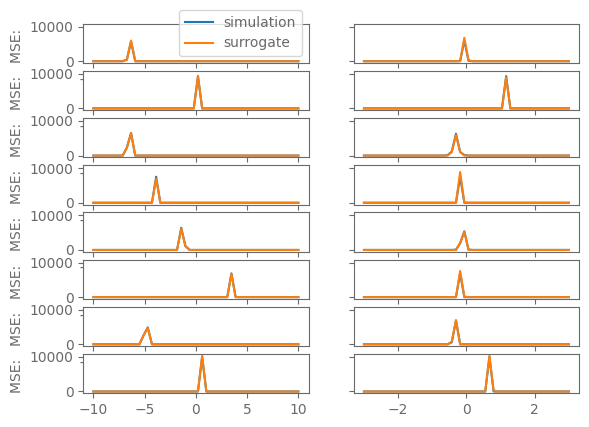

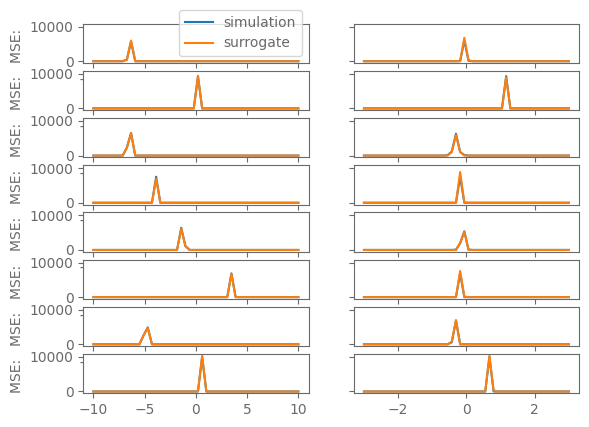

In [10]:
torch.set_default_device('cpu')
pc = [tensor_to_param_container(loss_min_params[i]) for i in range(loss_min_params.shape[0])]
Plot.plot_engines_comparison(engine, surrogate_engine, pc[:8], MultiLayer([0.]), )

In [75]:
compensated_parameters_selected = uncompensated_parameters_selected + offsets_selected
tensor_list_to_param_container_list = lambda input_param_tensor: [tensor_to_param_container(input_param_tensor[i].squeeze()) for i in range(input_param_tensor.shape[0])]

def simulate_param_tensor(input_param_tensor):
    pc = tensor_list_to_param_container_list(input_param_tensor)
    engine_output = engine.run(pc, MultiLayer([0.]))
    return ray_output_to_tensor(engine_output, 'ImagePlane')
observed_rays = simulate_param_tensor(compensated_parameters_selected)
interval_best_rays = simulate_param_tensor(loss_min_params)
uncompensated_rays = simulate_param_tensor(uncompensated_parameters_selected)

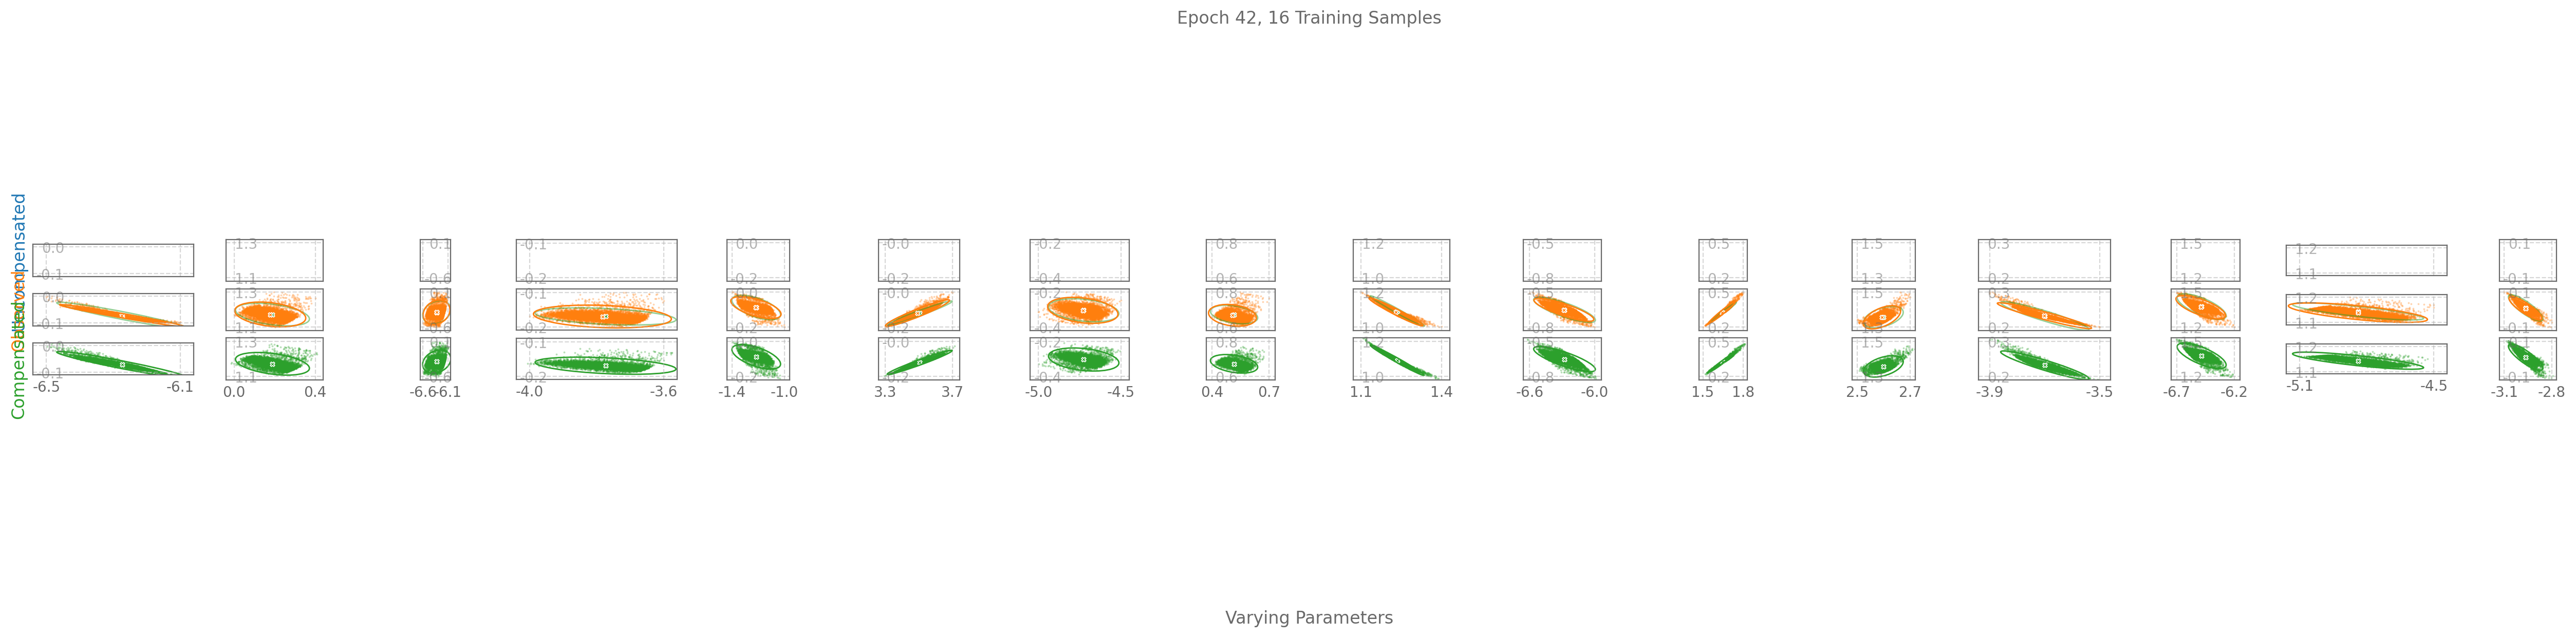

In [76]:
compensation_plot = Plot.compensation_plot(
        interval_best_rays,
        observed_rays,
        uncompensated_rays,
        epoch=42,
        training_samples_count=len(observed_rays),
    )

In [113]:
parameter_comparison_plot = Plot.plot_param_comparison(
    predicted_params=tensor_list_to_param_container_list(loss_min_params.squeeze().unsqueeze(0)),
    epoch=42,
    training_samples_count=len(observed_rays),
    search_space=params(),
    real_params=tensor_list_to_param_container_list(compensated_parameters_selected)[0],
)

RuntimeError: a Tensor with 34 elements cannot be converted to Scalar

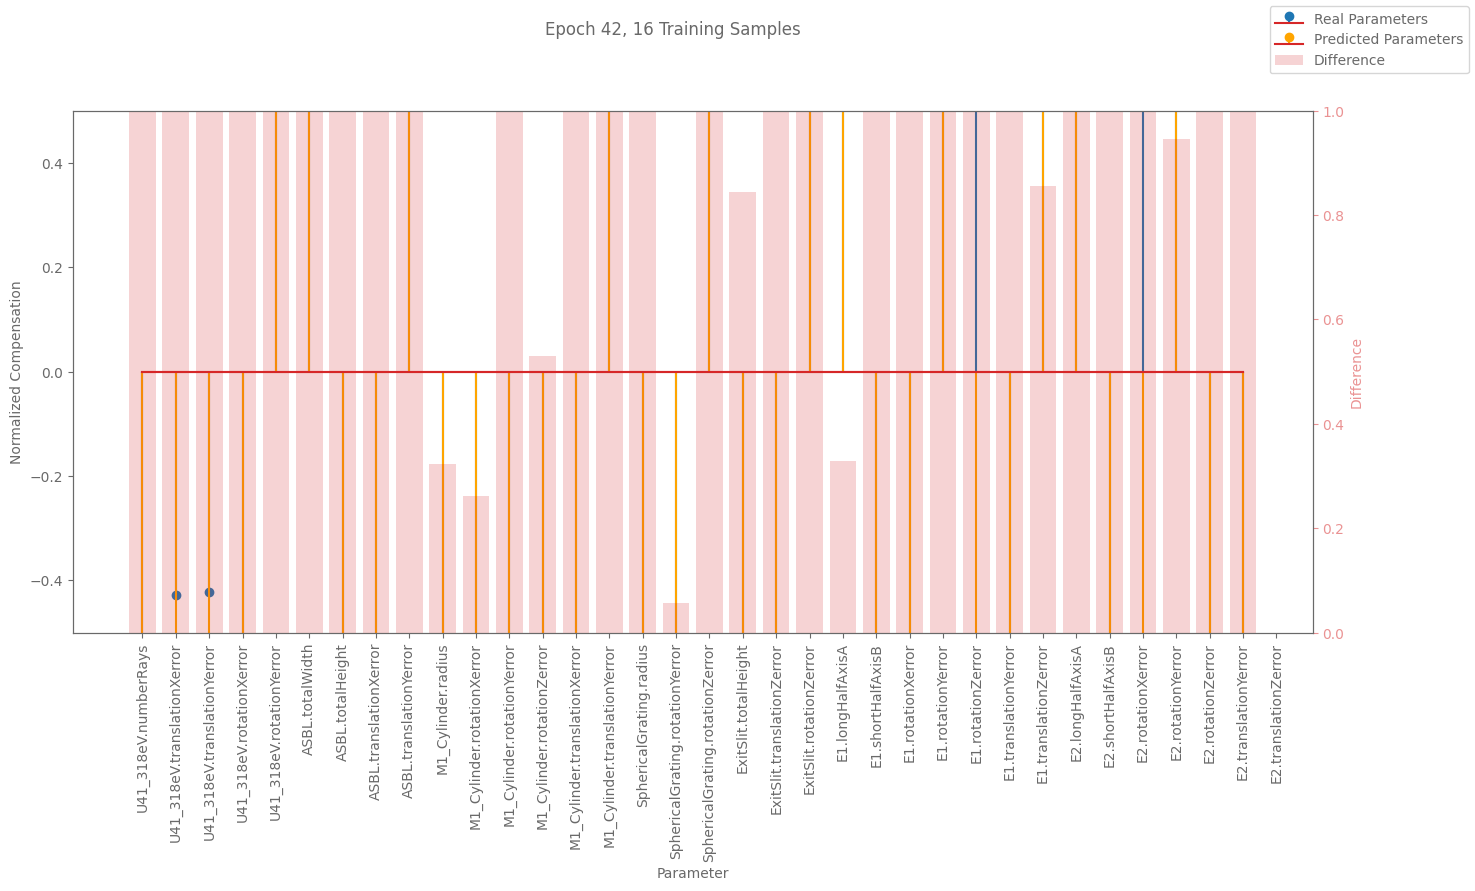

In [116]:
parameter_comparison_plot = Plot.plot_param_comparison(
    predicted_params=tensor_to_param_container(offsets_selected.squeeze()),
    epoch=42,
    training_samples_count=len(observed_rays),
    search_space=RayOptimization.limited_search_space(params(), RandomGenerator(42), max_deviation=max_offset),
    real_params=tensor_list_to_param_container_list(loss_min_params[0] - compensated_parameters_selected.squeeze())[1],
)

In [121]:
tensor_to_param_container(offsets_selected.squeeze())

offsets_selected.min()

tensor(-0.1636, device='cuda:0')

In [109]:
offsets_selected.shape

torch.Size([1, 1, 34])